In [1]:
import torch

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from collidium import *

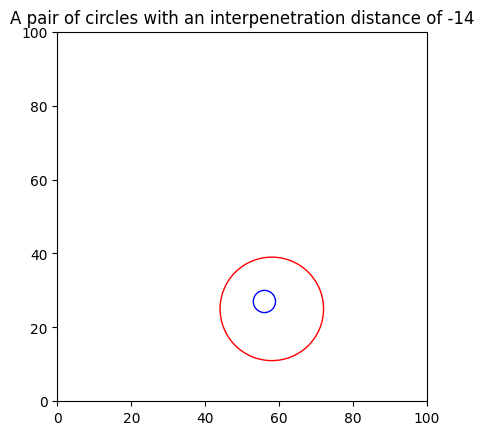

In [2]:
circles_interpenetration_distance_dataset_generator(8000, 0.5, 'train_interpenetration_distances.csv')
circles_interpenetration_distance_dataset_generator(2000, 0.5, 'test_interpenetration_distances.csv')
interpenetration_distance_random_figure_generator('train_interpenetration_distances.csv')

In [3]:
training_data = InterpenetrationDistancesDataset('train_interpenetration_distances.csv')
test_data = InterpenetrationDistancesDataset('test_interpenetration_distances.csv')
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [4]:
learning_rate = 1e-3
weight_decay = 1e-5
batch_size = 64
epochs = 10
model = ShallowNetInterpenetrationDistances(input_size=6, hidden_size=32, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, total_mae = 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        y_hat = model(X)

        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        total_mae += torch.abs(y_hat - y).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_mae = total_mae / len(dataloader.dataset)

    print(f"Train Error: \n MAE: {avg_mae:.2g}, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_mae

def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, total_mae = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)

            loss = loss_fn(y_hat, y)
            total_loss += loss.item() * X.size(0)
            total_mae += torch.abs(y_hat - y).sum().item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_mae = total_mae / len(dataloader.dataset)

    print(f"Test Error: \n MAE: {avg_mae:.2g}, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_mae

Train Error: 
 MAE: 25, Avg loss: 9.2e+02 

Test Error: 
 MAE: 22, Avg loss: 7e+02 

Train Error: 
 MAE: 17, Avg loss: 4.3e+02 

Test Error: 
 MAE: 12, Avg loss: 2.4e+02 

Train Error: 
 MAE: 8.6, Avg loss: 1.2e+02 

Test Error: 
 MAE: 5.5, Avg loss: 51 

Train Error: 
 MAE: 3.7, Avg loss: 26 

Test Error: 
 MAE: 2.5, Avg loss: 14 

Train Error: 
 MAE: 2.1, Avg loss: 8.8 

Test Error: 
 MAE: 1.7, Avg loss: 7.7 

Train Error: 
 MAE: 1.6, Avg loss: 5.7 

Test Error: 
 MAE: 1.5, Avg loss: 5.8 

Train Error: 
 MAE: 1.4, Avg loss: 4.4 

Test Error: 
 MAE: 1.4, Avg loss: 4.5 

Train Error: 
 MAE: 1.3, Avg loss: 3.5 

Test Error: 
 MAE: 1.2, Avg loss: 3.7 

Train Error: 
 MAE: 1.2, Avg loss: 2.8 

Test Error: 
 MAE: 1.1, Avg loss: 3 

Train Error: 
 MAE: 1, Avg loss: 2.4 

Test Error: 
 MAE: 1, Avg loss: 2.7 



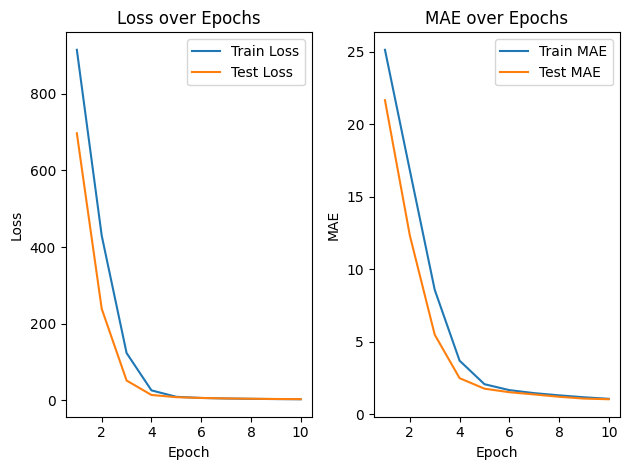

In [6]:
train_loss = []
train_mae = []
test_loss = []
test_mae = []
epochs_range = range(1, epochs + 1)

for epoch in epochs_range:
    epoch_train_loss, epoch_train_mae = train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_mae = test_loop(test_dataloader, model, loss_fn)
    train_loss.append(epoch_train_loss)
    train_mae.append(epoch_train_mae)
    test_loss.append(epoch_test_loss)
    test_mae.append(epoch_test_mae)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, test_mae, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('interpenetration_distances_train_test_plot.png')

In [7]:
torch.save(model, 'interpenetration_distances_model.pth')